#Framing the Problem Statement

* The Problem involves predicting the House prices in Bangalore given the various features about the house.
* This is a __Supervised Machine__ learning __Regression__
 task because we have labels available with us in the training dataset and the we need to predict the House prices which is a continuous number, hence a Supervised Regression task.
* We can use either MSE or RMSE as metrics as it is a regression task.


# Collect the data

I am using a Kaggle dataset by the name: ["Bengaluru House Price Data"](https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data).

The data is available in **CSV** format and can be downloaded on local machine. So we can import the CSV file into a Pandas Dataframe and analyse easily.

In [2]:
# Importing necessary libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor

In [3]:
import warnings
warnings.filterwarnings("ignore")

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Explore & Prepare the data

In [5]:
# Reading the CSV file into a dataframe
df = pd.read_csv('./Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
# There are approximately 13k records in the dataset
len(df)

13320

## Feature Description

> As we can see below, there are 2 numerical independent variables and 6 categorical variables.

* Numerical variables: **`bath, balcony`**
* Categorical variables: **`area_type, availability, location, size, society, total_sqft`**
* Target variable: **`price`**



**Note:** The variable `total_sqft` should be a numerical variable but instead it is of `object` type (meaning categorical variable). It is because the `dtype` of the variable is `str`. We can easily change it to numerical variable by changing its `dtype` to float.

In [7]:
# Description of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


## Missing Values

Also, there 5 features with missing values in them. So we need to treat them as well.

* Now if we look closely at these features and check if the Missing values in these features are because they don't exist then the answer would be **No**. Every house should have a **`location, size, society, number of bathrooms and balcony`**.

In [8]:
missing_cols = [col for col in df.columns if any(df[col].isna())]
missing_cols

['location', 'size', 'society', 'bath', 'balcony']

Text(0, 0.5, 'Missing counts')

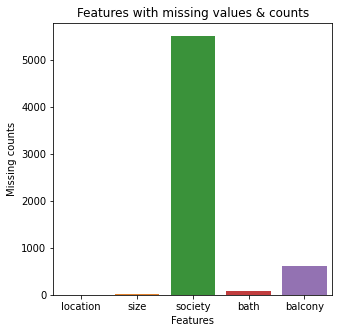

In [9]:
# Plot for missing values in each feature
missing_counts = [df[col].isna().sum() for col in missing_cols]

plt.figure(figsize=(5,5))
sns.barplot(x=missing_cols, y=missing_counts)
plt.title('Features with missing values & counts')
plt.xlabel('Features')
plt.ylabel('Missing counts')

## Exploring the Numerical Features
* The Numerical features in the dataset are: **`bath, balcony`**

* But if observe closely then **`size & total_sqft`** should be numerical features by definition. So I'll proceed considering them as numerical features but before that we need to convert them into numerical format.

### Size

This feature defines the number of rooms a house has (including bedroom, hall & kitchen to be specific). 

Also the data type of this feature is `str` so we'll need to convert it to numbers to analyse better.

In [10]:
# Unique values in size feature
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [11]:
df_modified = df.copy() #Copy the dataframe to modify it

# Transform the size feature into numerical format
def convert_size(x):
  if pd.isnull(x):
    return np.nan
  elif 'RK' in x:
    return int(x.split(' ')[0]) + 1 #Total number of rooms in a RK
  else:
    return int(x.split(' ')[0]) + 2 #Total number of rooms in a BHK/Bedroom

# Apply the transformation on size feature
df_modified['size'] = df_modified['size'].apply(convert_size)
df_modified.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,4.0,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,6.0,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,5.0,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,5.0,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,4.0,NaN,1200,2.0,1.0,51.00


Text(0, 0.5, 'Count')

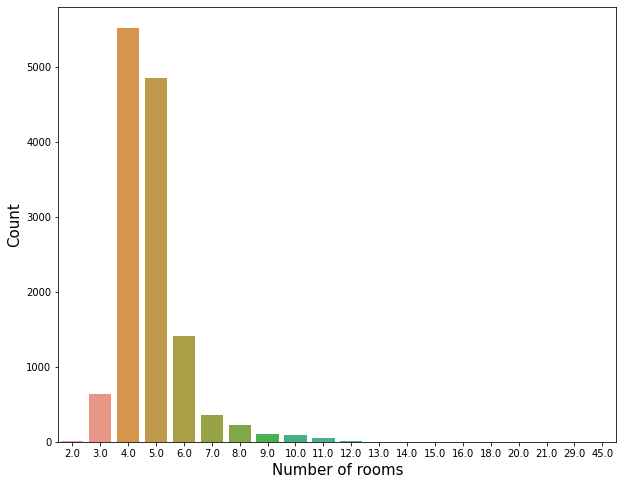

In [12]:
# Visualize the number of rooms in each house
plt.figure(figsize=(10,8))
sns.countplot(x='size', data=df_modified)
plt.xlabel('Number of rooms', fontsize=15)
plt.ylabel('Count', fontsize=15)

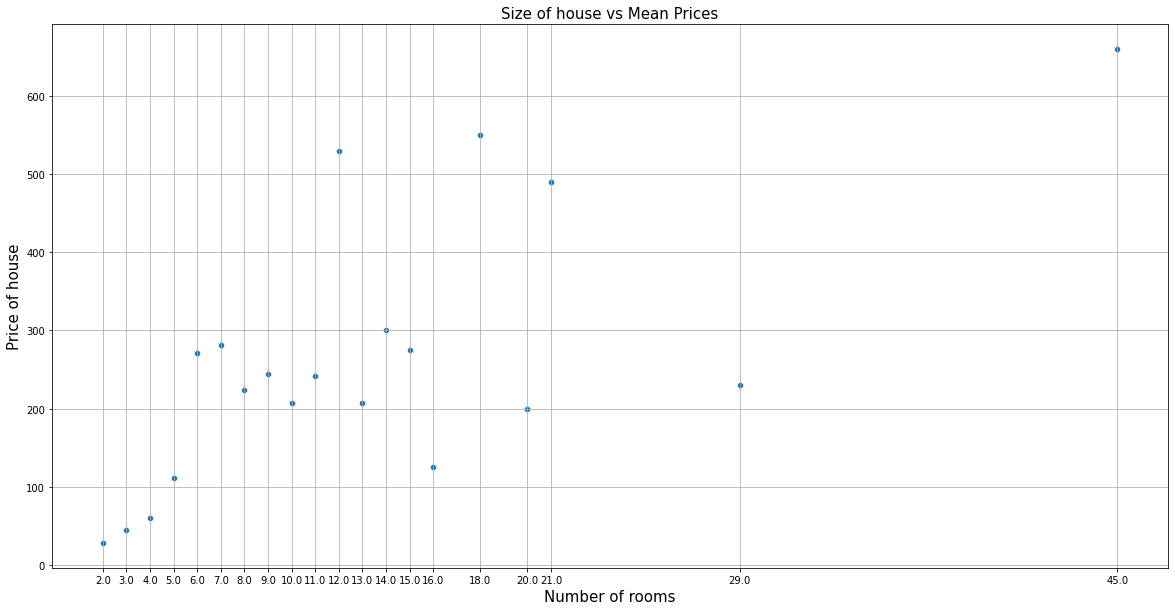

In [13]:
# Plot size vs Price 
group = df_modified.groupby('size')['price'].mean()

plt.figure(figsize=(20,10))
sns.scatterplot(x=group.index, y=group.values)
plt.title('Size of house vs Mean Prices', fontsize=15)
plt.xlabel('Number of rooms', fontsize=15)
plt.xticks(ticks=group.index, labels=group.index)
plt.ylabel('Price of house', fontsize=15)
plt.grid(True)

**Insights:**
* Again, 2-4 BHK (4-6 rooms due to the transformation) houses are most common in the dataset. 
* The biggest house in the dataset is a house with 43BHK (45 rooms). 
* The relation between size of the house and its mean price is almost linear, which means as the size of house increases price goes up. There are some exceptions but that may also be due to the locality of the house.

### Bath

This feature defines the number of bathrooms in the house. Let's visualize this feature.


Text(0.5, 0, 'Number of bathrooms')

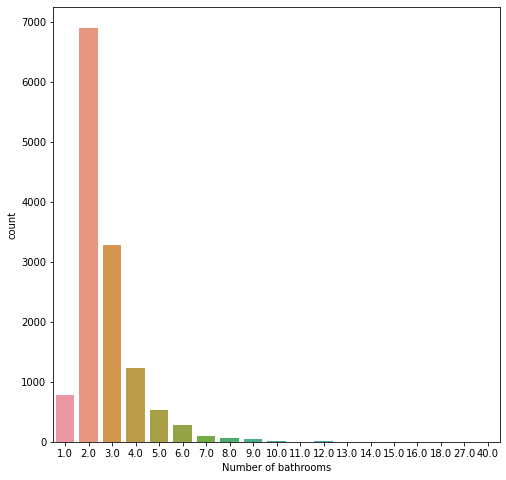

In [14]:
# Barplot of number of bathrooms in the house
plt.figure(figsize=(8,8))
sns.countplot(x='bath', data=df_modified)
plt.xlabel('Number of bathrooms')

**Insights:**
* Most houses in the dataset have 2-4 bathrooms.

* If you observe the plot, there are house with more than 15 bathrooms. Something is fishy about that! Let's check the data for these records.

In [15]:
# Checking records with more than 
df_modified[df_modified['bath']>15]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
1718,Super built-up Area,Ready To Move,2Electronic City Phase II,29.0,NaN,8000,27.0,0.0,230.0
3379,Super built-up Area,Ready To Move,1Hanuman Nagar,21.0,NaN,2000,16.0,NaN,490.0
3609,Super built-up Area,Ready To Move,Koramangala Industrial Layout,18.0,NaN,10000,16.0,NaN,550.0
4684,Plot Area,Ready To Move,Munnekollal,45.0,NaN,2400,40.0,0.0,660.0
11559,Plot Area,18-Apr,1Kasavanhalli,20.0,HMwerCo,1200,18.0,NaN,200.0


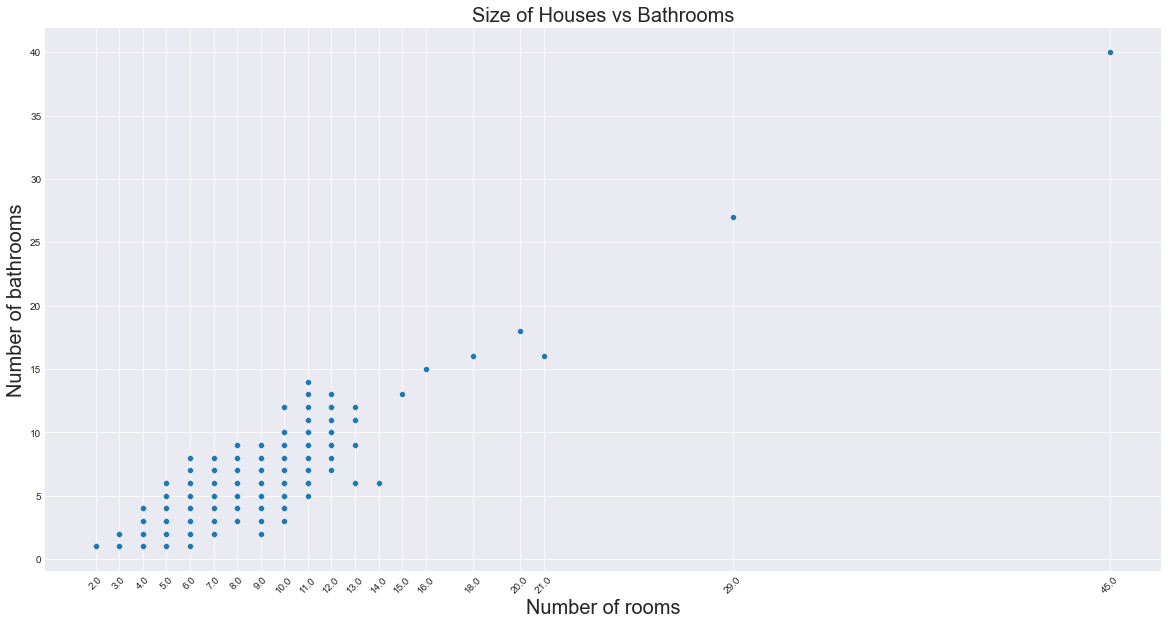

In [16]:
# Plot of size vs bathrooms
plt.figure(figsize=(20,10))
plt.style.use('seaborn-dark')
sns.scatterplot(x='size', y='bath', data=df_modified)
plt.title('Size of Houses vs Bathrooms', fontsize=20)
plt.xlabel('Number of rooms', fontsize=20)
plt.xticks(ticks=df_modified['size'].unique(), labels=df_modified['size'].unique(), rotation=45)
plt.ylabel('Number of bathrooms', fontsize=20)
plt.grid(True)

**Insights:**
* Now, if we compare `bath` with `size` feature then the number of bathrooms are approximately equal or lesser than the number of rooms in the house, which is fair. The records where number of bathrooms are greater than number of rooms (including hall & kitchen) can be dropped.

* Also, in Bangalore most of the houses are multifloored which might be the reason of many rooms in small area (e.g. 43BHK in 2400 sq.ft Plot area). Visit this [link](https://www.99acres.com/independent-house-in-doddanagamangala-bangalore-south-ffid) and see for yourself.



In [17]:
# Dropping records where number of bathrooms are higher than size of house
df_modified = df_modified[df_modified['bath'] <= df_modified['size']]
df_modified.shape

(13231, 9)

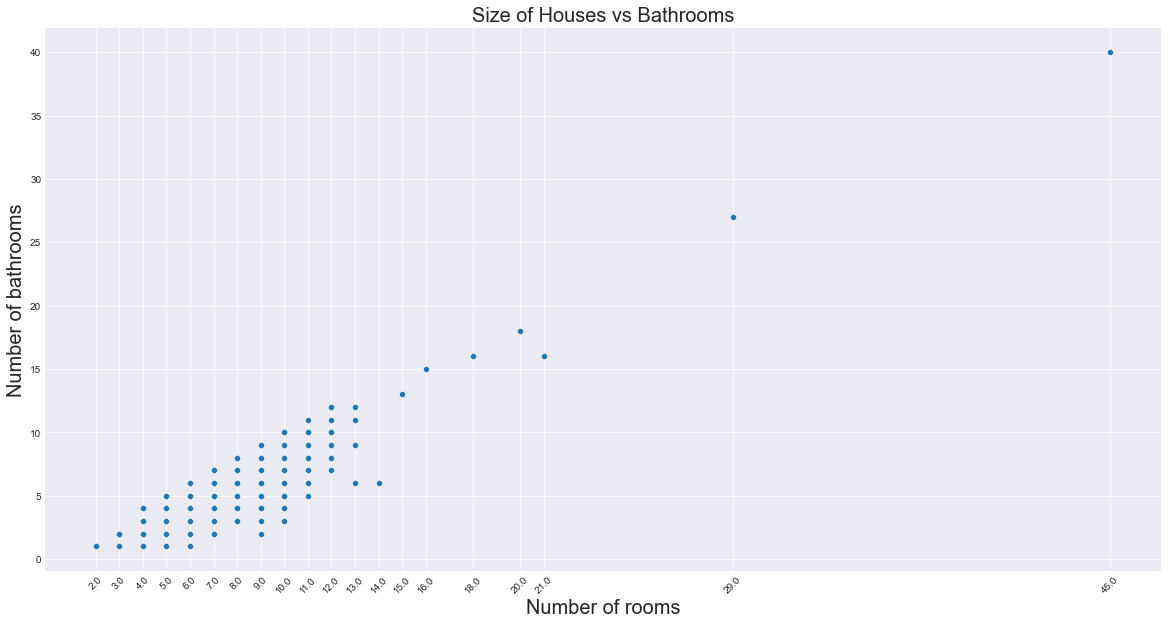

In [18]:
# Plot of size vs bathrooms after dropping records
plt.figure(figsize=(20,10))
sns.scatterplot(x='size', y='bath', data=df_modified)
plt.title('Size of Houses vs Bathrooms', fontsize=20)
plt.xlabel('Number of rooms', fontsize=20)
plt.xticks(ticks=df_modified['size'].unique(), labels=df_modified['size'].unique(), rotation=45)
plt.ylabel('Number of bathrooms', fontsize=20)
plt.grid(True)

### Balcony

This feature defines the number of balconies a house has. 

There are many records in the dataset where the number of balconies for houses are not reported at all and thus are NaN.


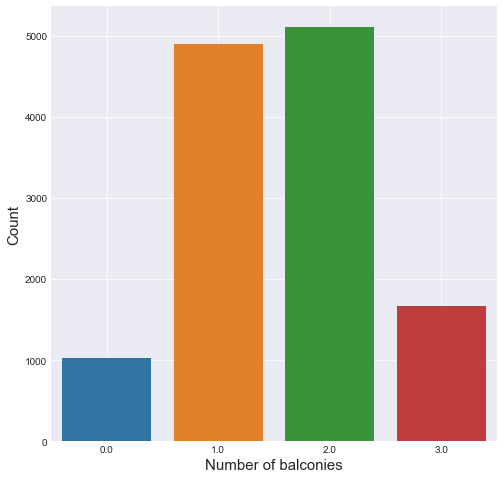

In [19]:
# Plot the number of balconies 
plt.figure(figsize=(8,8))
sns.countplot(x='balcony', data=df_modified)
plt.xlabel('Number of balconies', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(True)

In [20]:
# Balconies vs size
groups = df_modified.groupby('size')['balcony']
for key, grp in groups:
  b=Counter()
  b.update(grp.dropna().values)
  bathroom = b.most_common(1)
  print(f'Size of the house: {int(key)}, Number of bathrooms: {int(bathroom[0][0]) if len(bathroom)==1 else "NaN"}')

Size of the house: 2, Number of bathrooms: 0
Size of the house: 3, Number of bathrooms: 1
Size of the house: 4, Number of bathrooms: 1
Size of the house: 5, Number of bathrooms: 2
Size of the house: 6, Number of bathrooms: 2
Size of the house: 7, Number of bathrooms: 2
Size of the house: 8, Number of bathrooms: 2
Size of the house: 9, Number of bathrooms: 3
Size of the house: 10, Number of bathrooms: 2
Size of the house: 11, Number of bathrooms: 3
Size of the house: 12, Number of bathrooms: 3
Size of the house: 13, Number of bathrooms: 3
Size of the house: 14, Number of bathrooms: 2
Size of the house: 15, Number of bathrooms: 0
Size of the house: 16, Number of bathrooms: 0
Size of the house: 18, Number of bathrooms: NaN
Size of the house: 20, Number of bathrooms: NaN
Size of the house: 21, Number of bathrooms: NaN
Size of the house: 29, Number of bathrooms: 0
Size of the house: 45, Number of bathrooms: 0


**Insights:**

* There are maximum of 3 balcony houses in the dataset, where most houses have either 1 or 2 balconies.
* As the size of the house increases the number of balconies also increase with few exceptions where largest house has no balcony at all.

### Total Sqft

This feature defines the area of house in sq. ft.

Now the data type of this feature is `str`, so we'll have to convert it into numerical format first to analyse it better.

In [21]:
# Unique value in total_sqft feature
df_modified['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

As you can see, the number of `total_sqft` feature are in string format but there are some records where the area is 
* a range (e.g. **1133-1384**) 
* in sq. meters (e.g. **78.03Sq. Meter**) (conversion 1 sq.m = 10.7639 sq.ft)
* in Perches  (e.g. **4125Perch**) (conversion 1 Perch = 272.25 sq.ft)
* in Guntha  (e.g. **38Guntha**) (conversion 1 Guntha = 1089 sq.ft)
* in Acres  (e.g. **2Acres**) (conversion 1 Acre = 43560 sq.ft)
* in sq. yards  (e.g. **45Sq. Yards**) (conversion 1 sq.yard = 9 sq.ft)
* in Cents  (e.g. **3Cents**) (conversion 1 cent = 435.6 sq.ft)
* in Grounds  (e.g. **1Grounds**) (conversion 1 ground = 2400 sq.ft)

I'll be removing records with area in metrics other than sq.ft (e.g sq. m, perch, etc.) because they end adding outliers to the `total_sqft` feature.

In [22]:
# Transform total_sqft to numerical feature
def convert_to_sqft(x):
    try:
      if ' - ' in x:
          a, b = x.split(' - ')
          return (float(a) + float(b))/2
      else:
          return float(x)
    except:
      return None

# Applying the transformation to total_sqft feature
df_modified['total_sqft'] = df_modified['total_sqft'].apply(convert_to_sqft)
df_modified = df_modified[~df_modified['total_sqft'].isna()]
df_modified.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,4.0,Coomee,1056.0,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,6.0,Theanmp,2600.0,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,5.0,NaN,1440.0,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,5.0,Soiewre,1521.0,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,4.0,NaN,1200.0,2.0,1.0,51.00


Text(0.5, 1.0, 'Histogram of Total_sqft feature')

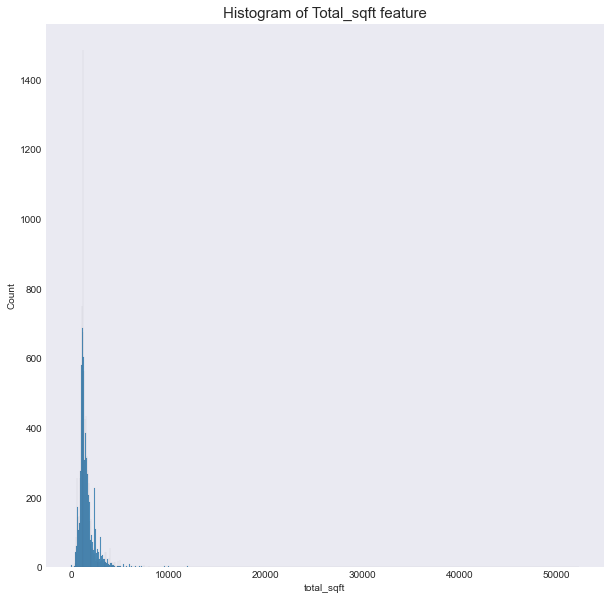

In [23]:
# Histogram of total_sqft feature
plt.figure(figsize=(10,10))
sns.histplot(x=df_modified['total_sqft'])
plt.title('Histogram of Total_sqft feature', fontsize=15)

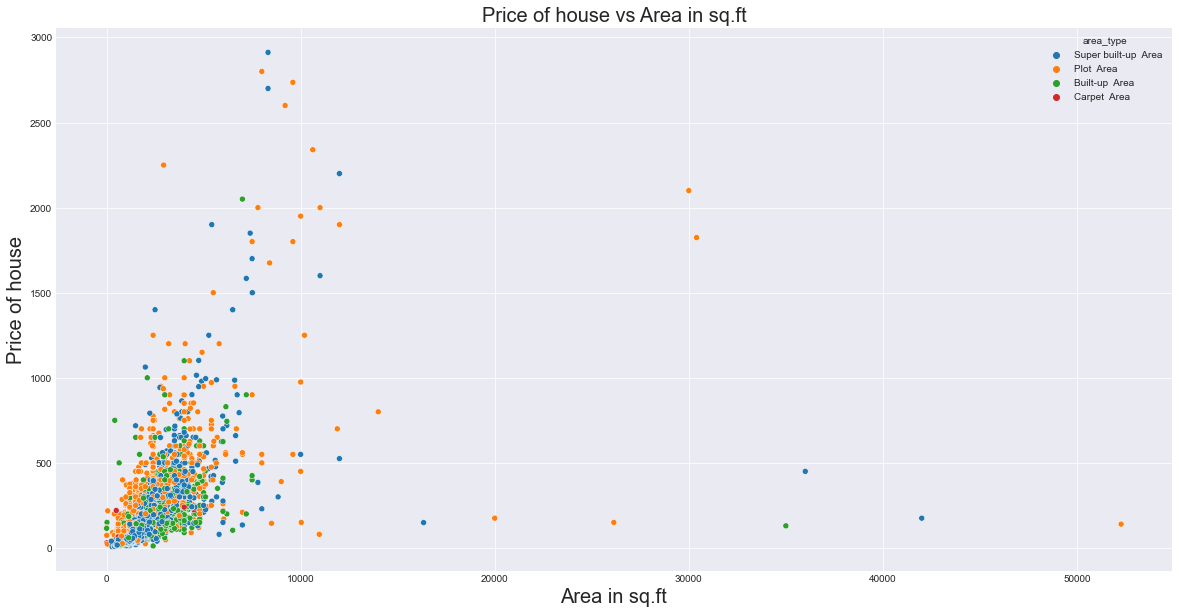

In [24]:
# Plot size of house vs the total_sqft
plt.figure(figsize=(20,10))
plt.style.use('seaborn-dark')

sns.scatterplot(x='total_sqft', y='price', hue='area_type', data=df_modified)
plt.title('Price of house vs Area in sq.ft', fontsize=20)
plt.xlabel('Area in sq.ft', fontsize=20)
plt.ylabel('Price of house', fontsize=20)
plt.grid(True)

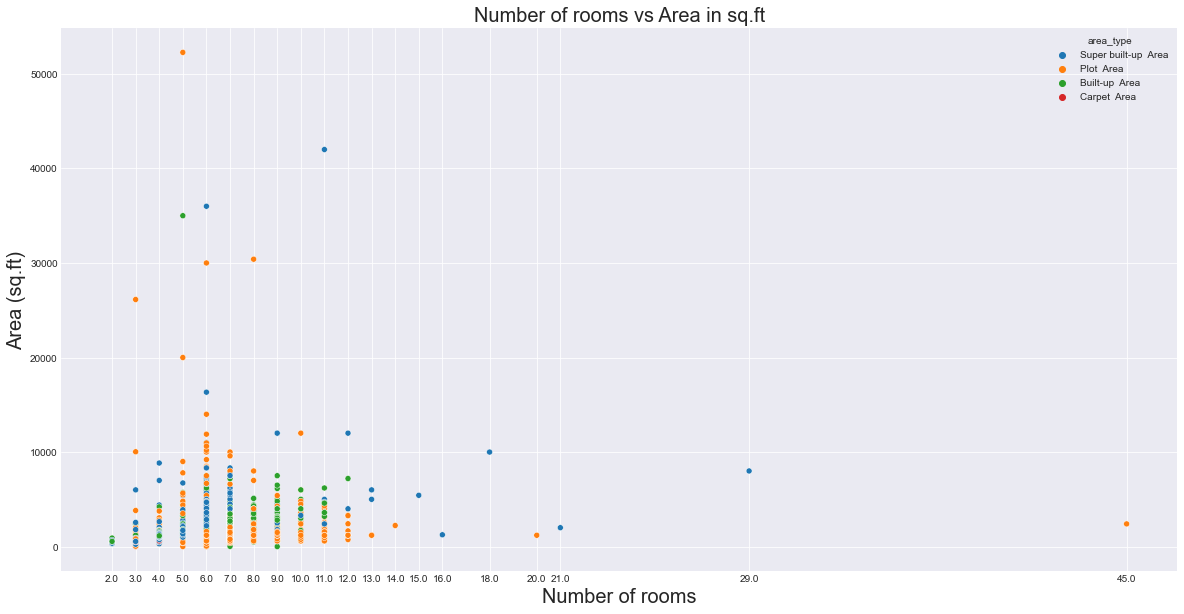

In [25]:
# Plot size of house vs the total_sqft
plt.figure(figsize=(20,10))

sns.scatterplot(x='size', y='total_sqft', hue='area_type', data=df_modified)
plt.title('Number of rooms vs Area in sq.ft', fontsize=20)
plt.xlabel('Number of rooms', fontsize=20)
plt.xticks(ticks=df_modified['size'].unique(), labels=df_modified['size'].unique())
plt.ylabel('Area (sq.ft)', fontsize=20)
plt.grid(True)

**Insights:**
* From the histogram, we find that the `total_sqft` feature fairly follows a Log-Normal distribution. (histogram is created after taking log of values and it approximately follows normal distribution hence log-normal)

* From the 2nd graph, it is clear that there are some records where the area of house is absurdly high and mostly for lesser number of rooms.
Most of these outliers are plot area type (land area without any construction). Even the super-built up areas can't be such high values. So we can drop these records as they're less in count.

* Also as the number of rooms increase the area in sq.ft should also increase but the graph doesn't reflect that. It also indicates that area in sq.ft depends on the `area_type`. `total_sqft` can be less for `plot area` type and still have more rooms because in Bangalore houses are usually multifloored. Visit this [link](https://www.99acres.com/independent-house-in-doddanagamangala-bangalore-south-ffid) which reinforces the above fact.


## Exploring the Categorical Features

The Categorical features in the dataset are: **`area_type, availability, location, society`** (as per `df.info()`)





### Area type

There are 4 types of area in this feature namely:
* Plot area
* Carpet area
* Built-up area
* Super Built-up area

You can read up about these area types from this blog: [Link](https://www.magicbricks.com/blog/what-is-carpet-area/114783.html#:~:text=According%20to%20Real%20Estate%20Regulatory,covered%20by%20the%20internal%20partition)

In [26]:
# Finding the labels in area_type
df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

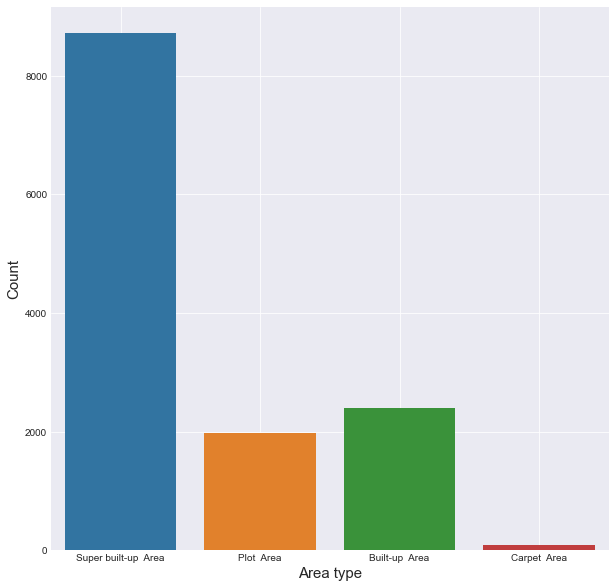

In [27]:
# Bar plot of area_type features
plt.figure(figsize=(10,10))
sns.countplot(x='area_type', data=df_modified)
plt.xlabel('Area type', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(True)

**Insights**
* From the countplot, we know that most of area mentioned in the dataset are of the type **Super Built-up/ Built-up**. 

### Location

This is feature define the locality where the house is located. This is feature influences the price of a house a lot.

In [28]:
# Unique locations in the dataset
unique_locations = df_modified['location'].unique()
print(f'There are {len(unique_locations)} in this dataset namely: \n\n{unique_locations}')

There are 1299 in this dataset namely: 

['Electronic City Phase II' 'Chikka Tirupathi' 'Uttarahalli' ...
 '12th cross srinivas nagar banshankari 3rd stage' 'Havanur extension'
 'Abshot Layout']


In [29]:
# Frequency of locations in dataset
loc_counts = df_modified['location'].value_counts()
print(f'Top 5 most frequent locations in the dataset are: \n\n{list(loc_counts[:5].index)}\n')
print(f'Frequency counts: \n\n{loc_counts}')

Top 5 most frequent locations in the dataset are: 

['Whitefield', 'Sarjapur  Road', 'Electronic City', 'Kanakpura Road', 'Thanisandra']

Frequency counts: 

Whitefield                   532
Sarjapur  Road               392
Electronic City              301
Kanakpura Road               264
Thanisandra                  231
                            ... 
Indiranagar HAL 2nd Stage      1
Maruthi HBCS Layout            1
K R C kothanur                 1
1Channasandra                  1
Abshot Layout                  1
Name: location, Length: 1298, dtype: int64


**Insights:**

* There are locations in the dataset which appear very less number of times. Later we need to encode the `location` feature and encoding `1305` unique locations will be difficult. So, what we can do is group less frequent locations (count<10) in 1 category called `Other` 

In [30]:
# Gathering location which have frequency less than 10
less_freq_loc = list(loc_counts[loc_counts<=10].index)
df_modified.loc[:, 'location'] = df_modified['location'].apply(lambda x: 'Other' if x in less_freq_loc else x)
df_modified.head(10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,4.0,Coomee,1056.0,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,6.0,Theanmp,2600.0,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,5.0,NaN,1440.0,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,5.0,Soiewre,1521.0,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,4.0,NaN,1200.0,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,4.0,DuenaTa,1170.0,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,6.0,Jaades,2732.0,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,6.0,Brway G,3300.0,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,5.0,NaN,1310.0,3.0,1.0,63.25
9,Plot Area,Ready To Move,Other,8.0,NaN,1020.0,6.0,NaN,370.00


### Availability & Society

These features define where the house will be available and name of the society respectively.

I think these features don't influence the price. So I'll be dropping them. Also you should look at society names, not even one makes sense!!😂

In [31]:
# Dropping availability and society features
df_modified.drop(['availability', 'society'], axis=1, inplace=True)
df_modified.head(10)

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,4.0,1056.0,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,6.0,2600.0,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,5.0,1440.0,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,5.0,1521.0,3.0,1.0,95.00
4,Super built-up Area,Kothanur,4.0,1200.0,2.0,1.0,51.00
5,Super built-up Area,Whitefield,4.0,1170.0,2.0,1.0,38.00
6,Super built-up Area,Old Airport Road,6.0,2732.0,4.0,NaN,204.00
7,Super built-up Area,Rajaji Nagar,6.0,3300.0,4.0,NaN,600.00
8,Super built-up Area,Marathahalli,5.0,1310.0,3.0,1.0,63.25
9,Plot Area,Other,8.0,1020.0,6.0,NaN,370.00


# Feature Engineering & Data cleaning

There is a metric which is common in real-estate industry: `Price per sq.ft`. I'll be adding this feature to identify and remove the outliers.

Also, we'll  have to handle the missing values.

## Outliers

### Total_sqft

I feel 10000 sqft is the threshold beyond which any value can be considered outliers. So we'll remove those outliers

In [32]:
df_modified = df_modified[df_modified['total_sqft']<10000]
df_modified.shape

(13159, 7)

### Price_per_sqft

* This feature defines the price of house per sq.ft of the area. This feature might help us remove outliers.

* What we can do is define a function which adds `price_per_sqft` feature and uses that remove outliers from the dataset.

In [33]:
# Adding a new feature price_per_sqft
df_modified.loc[:, 'price_per_sqft'] = np.round((df_modified['price']*100000)/df_modified['total_sqft'], 2)
df_modified.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_sqft
0,Super built-up Area,Electronic City Phase II,4.0,1056.0,2.0,1.0,39.07,3699.81
1,Plot Area,Chikka Tirupathi,6.0,2600.0,5.0,3.0,120.00,4615.38
2,Built-up Area,Uttarahalli,5.0,1440.0,2.0,3.0,62.00,4305.56
3,Super built-up Area,Lingadheeranahalli,5.0,1521.0,3.0,1.0,95.00,6245.89
4,Super built-up Area,Kothanur,4.0,1200.0,2.0,1.0,51.00,4250.00


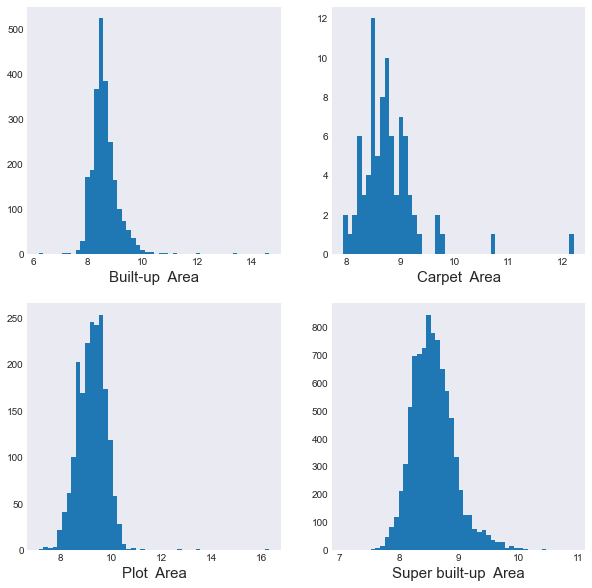

In [34]:
# Plot price_per_sqft vs area_type
groups = df_modified.groupby('area_type')['price_per_sqft']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
idx = list(zip([0,0,1,1],[0,1,0,1]))

for i, grp in enumerate(groups):
  row, col = idx[i]
  axes[row, col].hist(np.log(grp[1].values), bins=50)
  axes[row, col].set_xlabel(grp[0], fontsize=15)

**Insights:**

* If we plot the histogram of log of `price_per_sqft` feature based on the `area_type`, the distribution seems to approximately normal for each `area_type`. Also, there are presence of outliers which can removed by using the function below.

In [35]:
# Function to remove outliers using price_per_sqft feature
def remove_outliers(df):
  area_outlier_idx = []
  location_outlier_idx = []

  # removing outliers based on area_type
  for key1, group1 in df.groupby('area_type'):
    mean = np.mean(np.log(group1['price_per_sqft']))
    std = np.std(np.log(group1['price_per_sqft']))
    idxs1 = group1[(np.log(group1['price_per_sqft'])<(mean-std)) | (np.log(group1['price_per_sqft'])>(mean+std))].index.tolist()
    area_outlier_idx.extend(idxs1)
  
  # removing outliers based on location
  for key2, group2 in df.groupby('location'):
    mean = np.mean(np.log(group2['price_per_sqft']))
    std = np.std(np.log(group2['price_per_sqft']))
    idxs2 = group2[(np.log(group2['price_per_sqft'])<(mean-std)) | (np.log(group2['price_per_sqft'])>(mean+std))].index.tolist()
    location_outlier_idx.extend(idxs2)

  outlier_idx = area_outlier_idx + location_outlier_idx
  new_idx = np.setdiff1d(df.index, list(set(outlier_idx)))

  return df.loc[new_idx]

print(f'Shape of the dataset: {df_modified.shape}')
df_modified = remove_outliers(df_modified)
print(f'New shape of the dataset: {df_modified.shape}')
df_modified.head()

Shape of the dataset: (13159, 8)
New shape of the dataset: (7989, 8)


,area_type,location,size,total_sqft,bath,balcony,price,price_per_sqft
0,Super built-up Area,Electronic City Phase II,4.0,1056.0,2.0,1.0,39.07,3699.81
2,Built-up Area,Uttarahalli,5.0,1440.0,2.0,3.0,62.00,4305.56
3,Super built-up Area,Lingadheeranahalli,5.0,1521.0,3.0,1.0,95.00,6245.89
6,Super built-up Area,Old Airport Road,6.0,2732.0,4.0,NaN,204.00,7467.06
8,Super built-up Area,Marathahalli,5.0,1310.0,3.0,1.0,63.25,4828.24


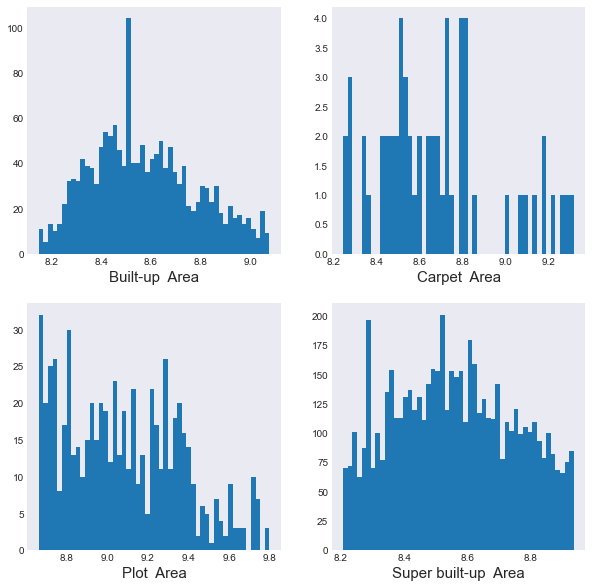

In [36]:
# Plot price_per_sqft vs area_type after the transformation
groups = df_modified.groupby('area_type')['price_per_sqft']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
idx = list(zip([0,0,1,1],[0,1,0,1]))

for i, grp in enumerate(groups):
  row, col = idx[i]
  axes[row, col].hist(np.log(grp[1].values), bins=50)
  axes[row, col].set_xlabel(grp[0], fontsize=15)

## Missing values

First we'll check the missing values in the dataset and if they're lesser in number we can drop them.

In [37]:
# Check the missing value records
df_modified.isna().sum()

area_type           0
location            1
size                0
total_sqft          0
bath                0
balcony           208
price               0
price_per_sqft      0
dtype: int64

In [38]:
# Since the number of missing value records are less we can drop them
print(f'Dataset shape before: {df_modified.shape}')
df_modified.dropna(inplace=True)
print(f'Dataset shape after removing missing value records: {df_modified.shape}')

Dataset shape before: (7989, 8)
Dataset shape after removing missing value records: (7780, 8)


## Encoding the categorical variables

We need to encode the 
* `location` feature which is a nominal categorical feature (which has no inherent order in it).
* `area_type` feature which can be considered ordinal because in terms of area generally *__Plot area < Carpet area < Built-up area < Super Built-up area__*. 

We can One-hot encode these features when using algorithms like Linear regression, Lasso/Ridge, SVM etc. While we can Label encode them when using tree-base algorithms like Random Forest, XGBoost etc.

In [39]:
# Dropping the price_per_sqft column
df_modified.drop('price_per_sqft', axis=1, inplace=True)
df_modified.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,4.0,1056.0,2.0,1.0,39.07
2,Built-up Area,Uttarahalli,5.0,1440.0,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,5.0,1521.0,3.0,1.0,95.00
8,Super built-up Area,Marathahalli,5.0,1310.0,3.0,1.0,63.25
10,Super built-up Area,Whitefield,5.0,1800.0,2.0,2.0,70.00


## Feature Selection

We'll use feature_importances of Decision Tree to select important features of training data.

In [40]:
# Features and target variables
X = df_modified.drop('price', axis=1)
y = df_modified['price']

In [41]:
# Splitting the dataset into training and test(hold-out) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

((6224, 6), (6224,)) ((1556, 6), (1556,))


In [42]:
# Label encoding categorical features
X_train_copy = X_train.copy()

le = OrdinalEncoder() 
X_train_copy.loc[:, ['area_type','location']] = le.fit_transform(X_train_copy[['area_type','location']])

X_train_copy.head()

,area_type,location,size,total_sqft,bath,balcony
12514,3.0,178.0,4.0,1020.0,2.0,2.0
4496,3.0,178.0,4.0,1100.0,2.0,2.0
11344,3.0,178.0,4.0,1000.0,2.0,1.0
4898,3.0,178.0,5.0,1230.0,2.0,2.0
6724,3.0,220.0,4.0,1050.0,2.0,2.0


<AxesSubplot:>

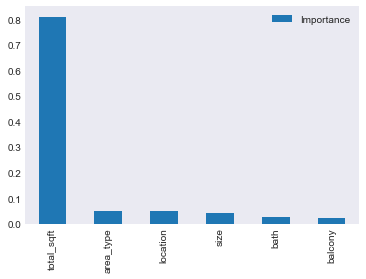

In [43]:
# Feature selection
extra_tree = ExtraTreeRegressor(random_state=42)
extra_tree.fit(X_train_copy, y_train)

feat_imp = pd.DataFrame(extra_tree.feature_importances_, columns=['Importance'], index=X_train_copy.columns)
feat_imp.sort_values(by='Importance',ascending=False).plot(kind='bar')

**Insights:**

* `balcony` has the least importance in the training data. So we can drop the column for algorithm like Linear regression.

In [44]:
# Dropping the balcony feature
X_train.drop('balcony', axis=1, inplace=True)
X_test.drop('balcony', axis=1, inplace=True)

# Model Building
We'll use several ML algorithms build a model:
* Linear regression
* Ridge regression
* Lasso regression
* Support Vector Regressor
* Decision Tree Regressor
* Random Forest Regressor
* Gradient Boosting Regressor
* XGBoost Regressor

## Linear Regression

As I mentioned before, we'll One-hot encode the `area_type & location` features for algorithms like Linear regression, Lasso regression, Support Vector regressor.

In [45]:
# Fit Linear Regression model on data and search for best params

# Numerical and Categorical features
num_features = X_train.select_dtypes(['int64','float64']).columns
cat_features = X_train.select_dtypes(['object']).columns

# Building Column Transformer for numerical & categorical features
col_transformer = ColumnTransformer([('ohc', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                                     ('scaler', StandardScaler(), num_features)])

# Pipeline
lr_pipe = Pipeline([('preprocessing', col_transformer),
                    ('lr', LinearRegression())])

# Grid Search params
param_grid = {'lr__fit_intercept':[True, False]}

# KFold crossvalidation & GridSearch
kfold = KFold(n_splits=5)
cv_lr = GridSearchCV(lr_pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1, error_score='raise')

cv_lr.fit(X_train, y_train)
print(f'Score: {cv_lr.best_score_}')
print(f'Best parameters: {cv_lr.best_params_}')

Score: 0.8706164921773049
Best parameters: {'lr__fit_intercept': True}


In [46]:
# Evaluating on train-test data
lr = cv_lr.best_estimator_
lr_test_score = lr.score(X_test, y_test)
print(f'Test r2 score: {lr_test_score}')

Test r2 score: 0.85274155545828


## Lasso Regression

In [47]:
# Fit Lasso Regression model on data and search for best params

# Building Column Transformer for numerical & categorical features
col_transformer = ColumnTransformer([('ohc', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                                     ('scaler', StandardScaler(), num_features)])

# Pipeline
lasso_pipe = Pipeline([('preprocessing', col_transformer),
                    ('lassor', Lasso())])

# Grid Search params
param_grid = {'lassor__alpha':[0.1, 1, 10]}

# KFold crossvalidation & GridSearch
kfold = KFold(n_splits=5)
cv_lasso = GridSearchCV(lasso_pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1, error_score='raise')

cv_lasso.fit(X_train, y_train)
print(f'Score: {cv_lasso.best_score_}')
print(f'Best parameters: {cv_lasso.best_params_}')

Score: 0.8339252497200164
Best parameters: {'lassor__alpha': 0.1}


In [48]:
# Evaluating on train-test data
lasso = cv_lasso.best_estimator_
lasso_test_score = lasso.score(X_test, y_test)
print(f'Test r2 score: {lasso_test_score}')

Test r2 score: 0.8091354611533529


## Ridge Regression

In [49]:
# Fit Ridge Regression model on data and search for best params

# Building Column Transformer for numerical & categorical features
col_transformer = ColumnTransformer([('ohc', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                                     ('scaler', StandardScaler(), num_features)])

# Pipeline
ridge_pipe = Pipeline([('preprocessing', col_transformer),
                    ('ridge', Ridge())])

# Grid Search params
param_grid = {'ridge__alpha':[0.01, 0.1, 1, 10, 100],
              'ridge__fit_intercept':[True, False]}

# KFold crossvalidation & GridSearch
kfold = KFold(n_splits=5)
cv_ridge = GridSearchCV(ridge_pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1, error_score='raise')

cv_ridge.fit(X_train, y_train)
print(f'Score: {cv_ridge.best_score_}')
print(f'Best parameters: {cv_ridge.best_params_}')

Score: 0.8707313695486139
Best parameters: {'ridge__alpha': 0.1, 'ridge__fit_intercept': True}


In [50]:
# Evaluating on train-test data
ridge = cv_ridge.best_estimator_
ridge_test_score = ridge.score(X_test, y_test)
print(f'Test r2 score: {ridge_test_score}')

Test r2 score: 0.8528863428902772


## Support Vector Regressor

In [53]:
# Fit Support Vector Regression model on data and search for best params

# Building Column Transformer for numerical & categorical features
col_transformer = ColumnTransformer([('ohc', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                                     ('scaler', StandardScaler(), num_features)])

# Pipeline
svr_pipe = Pipeline([('preprocessing', col_transformer),
                    ('svr', SVR())])

# Grid Search params
param_grid = {'svr__kernel':['rbf'],
              'svr__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'svr__gamma':[1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9]}

# KFold crossvalidation & RandomizedSearch
kfold = KFold(n_splits=5)
rcv_svr = RandomizedSearchCV(svr_pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1, n_iter=20)
rcv_svr.fit(X_train, y_train)
print(f'Score: {rcv_svr.best_score_}')
print(f'Best parameters: {rcv_svr.best_params_}')

Score: 0.8483342137097676
Best parameters: {'svr__kernel': 'rbf', 'svr__gamma': 0.1, 'svr__C': 100}


In [54]:
# Evaluating on train-test data
svr = rcv_svr.best_estimator_
svr_test_score = svr.score(X_test, y_test)
print(f'Test r2 score: {svr_test_score}')

Test r2 score: 0.8579827055527122


## Decision Tree

In [57]:
# Fit Decision Tree Regression model on data and search for best params

# Building Column Transformer for numerical & categorical features
col_transformer = ColumnTransformer([('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=242), cat_features),
                                     ('scaler', StandardScaler(), num_features)])

# Pipeline
dt_pipe = Pipeline([('preprocessing', col_transformer),
                    ('dt', DecisionTreeRegressor())])

# Grid Search params
param_grid = {'dt__max_depth':[5, 8, 15, 25, 30, None],
              'dt__min_samples_split':[1.0, 2, 5, 10, 15, 100],
              'dt__min_samples_leaf':[1, 2, 5, 10],
              'dt__max_features':['log2', 'sqrt', None]}

# KFold crossvalidation & GridSearch
kfold = KFold(n_splits=5)
gcv_dt = GridSearchCV(dt_pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1)

gcv_dt.fit(X_train, y_train)
print(f'Score: {gcv_dt.best_score_}')
print(f'Best parameters: {gcv_dt.best_params_}')

Score: 0.8076977463788186
Best parameters: {'dt__max_depth': 8, 'dt__max_features': None, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 15}


In [58]:
# Evaluating on train-test data
dt = gcv_dt.best_estimator_
dt_test_score = dt.score(X_test, y_test)
print(f'Test r2 score: {dt_test_score}')

Test r2 score: 0.7925448217241096


## Random Forest

In [59]:
# Fit Random Forest Regression model on data and search for best params

# Building Column Transformer for numerical & categorical features
col_transformer = ColumnTransformer([('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=242), cat_features),
                                     ('scaler', StandardScaler(), num_features)])

# Pipeline
rf_pipe = Pipeline([('preprocessing', col_transformer),
                    ('rf', RandomForestRegressor())])

# Grid Search params
param_grid = {'rf__n_estimators':[100, 200, 300, 500, 800, 1200],
              'rf__max_depth':[5, 8, 15, 20],
              'rf__min_samples_split':[1.0, 2, 5, 10, 15, 100],
              'rf__min_samples_leaf':[1, 2, 5, 10, 15, 20],
              'rf__max_features':['log2', 'sqrt', 'auto']}

# KFold crossvalidation & RandomizedSearch
kfold = KFold(n_splits=5)
rcv_rf = RandomizedSearchCV(rf_pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1, n_iter=20, random_state=42)

rcv_rf.fit(X_train, y_train)
print(f'Score: {rcv_rf.best_score_}')
print(f'Best parameters: {rcv_rf.best_params_}')

Score: 0.8404603205406389
Best parameters: {'rf__n_estimators': 500, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 20}


In [60]:
# Evaluating on train-test data
rf = rcv_rf.best_estimator_
rf_test_score = rf.score(X_test, y_test)
print(f'Test r2 score: {rf_test_score}')

Test r2 score: 0.8440381109181333


In [67]:
import joblib as j
with open('RF_model','wb') as f:
    j.dump(rf, f, compress=3)

In [68]:
%%time
rf = j.load(open('RF_model','rb'))

Wall time: 1.98 s


In [70]:
%%time
s_model = pickle.load(open('Stacked_model.pkl','rb'))

[15:14:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 99 ms


## GradientBoosting Regressor


In [71]:
# Fit GradientBoosting Regression model on data and search for best params

# Building Column Transformer for numerical & categorical features
col_transformer = ColumnTransformer([('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=242), cat_features),
                                     ('scaler', StandardScaler(), num_features)])

# Pipeline
gb_pipe = Pipeline([('preprocessing', col_transformer),
                    ('gb', GradientBoostingRegressor())])

# Grid Search params
param_grid = {'gb__n_estimators':[100, 200, 300, 500, 800, 1200],
              'gb__max_depth':[5, 8, 15, 20],
              'gb__subsample': [1.0, 0.9, 0.5, 0.2, 0.1],
              'gb__min_samples_split':[1.0, 2, 5, 10, 15, 100],
              'gb__min_samples_leaf':[1, 2, 5, 10, 15, 20],
              'gb__max_features':['log2', 'sqrt', 'auto']}

# KFold crossvalidation & RandomizedSearch
kfold = KFold(n_splits=5)
rcv_gb = RandomizedSearchCV(gb_pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1, n_iter=20, random_state=100)

rcv_gb.fit(X_train, y_train)
print(f'Score: {rcv_gb.best_score_}')
print(f'Best parameters: {rcv_gb.best_params_}')

Score: 0.8500537058082525
Best parameters: {'gb__subsample': 1.0, 'gb__n_estimators': 800, 'gb__min_samples_split': 5, 'gb__min_samples_leaf': 2, 'gb__max_features': 'sqrt', 'gb__max_depth': 5}


In [72]:
# Evaluating on train-test data
gb = rcv_gb.best_estimator_
gb_test_score = gb.score(X_test, y_test)
print(f'Test r2 score: {gb_test_score}')

Test r2 score: 0.878316936437574


## XGBoost

In [ ]:
# Fit XGBoost Regression model on data and search for best params

# Building Column Transformer for numerical & categorical features
col_transformer = ColumnTransformer([('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=242), cat_features),
                                     ('scaler', StandardScaler(), num_features)])

# Pipeline
xgb_pipe = Pipeline([('preprocessing', col_transformer),
                    ('xgb', XGBRegressor())])

# Bayes Search params
param_grid = {'xgb__n_estimators': Integer(100, 1000),
              'xgb__max_depth':Integer(5, 20),
              'xgb__eta': Real(0.01, 0.1),
              'xgb__gamma':Real(0.05, 1),
              'xgb__min_child_weight':Integer(1, 10),
              'xgb__subsample':Real(0.5, 1),
              'xgb__colsample_bytree':Real(0.5, 1),
              'xgb__reg_lambda':Real(0.01, 1),
              'xgb__reg_alpha':Integer(40, 180)}

# KFold crossvalidation & BayesSearch
kfold = KFold(n_splits=5)
rcv_xgb = BayesSearchCV(xgb_pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1, n_iter=20, random_state=42)

rcv_xgb.fit(X_train, y_train)
print(f'Score: {rcv_xgb.best_score_}')
print(f'Best parameters: {rcv_xgb.best_params_}')

In [ ]:
# Evaluating on train-test data
xgb = rcv_xgb.best_estimator_
xgb_test_score = xgb.score(X_test, y_test)
print(f'Test r2 score: {xgb_test_score}')

## Stacking

I'll use the 6 models for Stacking namely:
* SVR 
* XGBoost
* GradientBoost
* Ridge regression
* Linear regression
* Random Forest

In [87]:
# Stacking the model with best params
level0 = list()
level0.append(('svr', svr))
level0.append(('xgb', xgb))
level0.append(('gb', gb))
level0.append(('ridge', ridge))
level0.append(('linear', lr))
level0.append(('rf', rf))

# define meta learner model
level1 = LinearRegression()

# define the stacking ensemble
stacked_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

# Fit the stacked model
stacked_model.fit(X_train, y_train)
stacked_test_score = stacked_model.score(X_test, y_test)
print(f'Test score: {stacked_test_score}')

[08:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test score: 0.8754864434538456


## Comparison of models

In [88]:
# mean-std & dropping balcony
algos = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'SVR', 'DecisionTree Regression', 'RandomForest Regression', 'GradientBoost Regression', 'XGBoost Regression', 'Stacked model']
test_scores = [lr_test_score, lasso_test_score, ridge_test_score, svr_test_score, dt_test_score, rf_test_score, gb_test_score, xgb_test_score, stacked_test_score]

comparison = pd.DataFrame({'Test_scores': test_scores}, index=algos).sort_values(by='Test_scores', ascending=False)
comparison

,Test_scores
Stacked model,0.875486
GradientBoost Regression,0.875389
XGBoost Regression,0.867378
SVR,0.857983
Ridge Regression,0.852886
Linear Regression,0.852742
RandomForest Regression,0.843354
DecisionTree Regression,0.811337
Lasso Regression,0.809135


## Save the model

In [113]:
with open('Stacked_model.pkl','wb') as f:
  pickle.dump(stacked_model, f)